Found 10901 files belonging to 6 classes.
Found 2698 files belonging to 6 classes.


/tmp/ipykernel_30/5517672.py:42: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 173s 812ms/step - accuracy: 0.4475 - loss: 3.2928 - val_accuracy: 0.7632 - val_loss: 0.7099
Epoch 2/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 132s 772ms/step - accuracy: 0.6159 - loss: 0.8818 - val_accuracy: 0.7346 - val_loss: 0.7845
Epoch 3/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 134s 787ms/step - accuracy: 0.6285 - loss: 0.8767 - val_accuracy: 0.8369 - val_loss: 0.5124
Epoch 4/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 133s 781ms/step - accuracy: 0.6753 - loss: 0.7407 - val_accuracy: 0.8510 - val_loss: 0.4552
Epoch 5/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 136s 794ms/step - accuracy: 0.7042 - loss: 0.6932 - val_accuracy: 0.8677 - val_loss: 0.4364
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 587ms/step - accuracy: 0.8702 - loss: 0.4434
Test Accuracy: 86.77%


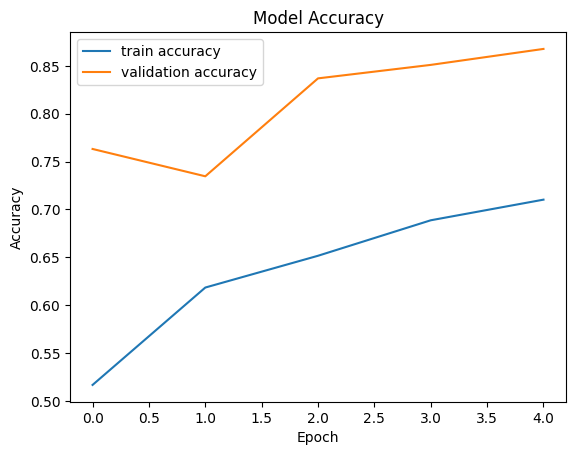

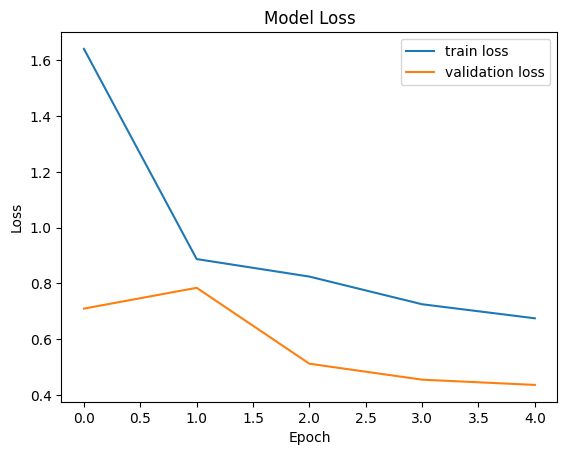

In [3]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Enable GPU Acceleration (already done in Kaggle settings)

# Define paths
dataset_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/'
train_data_dir = os.path.join(dataset_path, 'dataset/train/')
test_data_dir = os.path.join(dataset_path, 'dataset/test/')

# Use tf.data.Dataset for loading and preprocessing the images
BATCH_SIZE = 64
IMG_SIZE = (150, 150)

def load_dataset(data_dir):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',  # Change to categorical for multi-class
        shuffle=True
    )
    return dataset

# Load train and test datasets using tf.data.Dataset
train_dataset = load_dataset(train_data_dir)
test_dataset = load_dataset(test_data_dir)

# Apply optimizations
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Use MobileNetV2 pre-trained model as the base
def create_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False  # Freeze the base model layers for transfer learning

    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(6, activation='softmax')  # For six classes
    ])
    return model

# Create and compile the model
model = create_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with tf.data.Dataset
history = model.fit(
    train_dataset,
    epochs=5,  # Reduced number of epochs for quicker testing
    validation_data=test_dataset
)

# Save the trained model
model.save('/kaggle/working/my_fruit_classifier.h5')

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


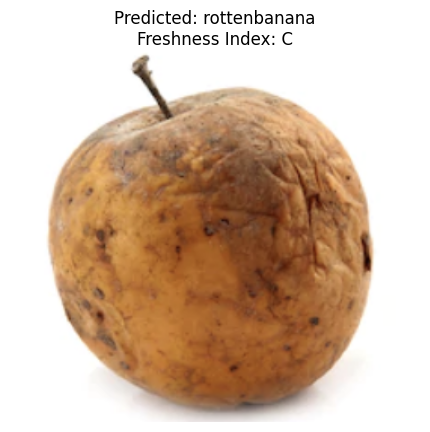

Predicted Class: rottenbanana
Freshness Index: C


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load the trained model
model = tf.keras.models.load_model('/kaggle/working/my_fruit_classifier.h5')

# Define a mapping from the six classes to the three freshness categories (A, B, C)
class_to_freshness = {
    0: 'A',  # Assuming class 0 is fresh (e.g., freshapples)
    1: 'A',  # Assuming class 1 is fresh (e.g., freshbanana)
    2: 'B',  # Assuming class 2 is edible (e.g., freshoranges)
    3: 'C',  # Assuming class 3 is rotten (e.g., rottenapples)
    4: 'C',  # Assuming class 4 is rotten (e.g., rottenbanana)
    5: 'C',  # Assuming class 5 is rotten (e.g., rottenoranges)
}

# Define a function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # Match the input size
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess (MobileNetV2 specific)
    return img_array

# Define a function to get the freshness index
def get_freshness_index(predicted_class):
    return class_to_freshness[predicted_class]  # Get freshness category (A, B, or C)

# Path to the image you want to test
test_image_path = "/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/rottenapples/Screen Shot 2018-06-07 at 2.21.09 PM.png"  # Replace with your image path

# Load and preprocess the image
img = load_and_preprocess_image(test_image_path)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions, axis=-1)[0]

# Get the predicted class name and freshness index
class_names = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']  # Replace with your class names
predicted_label = class_names[predicted_class]
freshness_index = get_freshness_index(predicted_class)

# Display the image and prediction
plt.imshow(image.load_img(test_image_path))  # Display the original image
plt.title(f'Predicted: {predicted_label}\nFreshness Index: {freshness_index}')
plt.axis('off')
plt.show()

# Print the prediction and freshness index
print(f"Predicted Class: {predicted_label}")
print(f"Freshness Index: {freshness_index}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


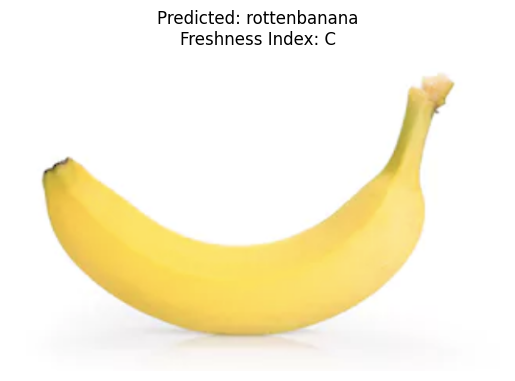

Predicted Class: rottenbanana
Freshness Index: C


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load the trained model
model = tf.keras.models.load_model('/kaggle/working/my_fruit_classifier.h5')

# Define a mapping from the six classes to the three freshness categories (A, B, C)
class_to_freshness = {
    0: 'A',  # Assuming class 0 is fresh (e.g., freshapples)
    1: 'A',  # Assuming class 1 is fresh (e.g., freshbanana)
    2: 'B',  # Assuming class 2 is edible (e.g., freshoranges)
    3: 'C',  # Assuming class 3 is rotten (e.g., rottenapples)
    4: 'C',  # Assuming class 4 is rotten (e.g., rottenbanana)
    5: 'C',  # Assuming class 5 is rotten (e.g., rottenoranges)
}

# Define a function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # Match the input size
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess (MobileNetV2 specific)
    return img_array

# Define a function to get the freshness index
def get_freshness_index(predicted_class):
    return class_to_freshness[predicted_class]  # Get freshness category (A, B, or C)

# Path to the image you want to test
test_image_path = "/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/freshbanana/Screen Shot 2018-06-12 at 10.00.37 PM.png"  # Replace with your image path

# Load and preprocess the image
img = load_and_preprocess_image(test_image_path)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions, axis=-1)[0]

# Get the predicted class name and freshness index
class_names = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']  # Replace with your class names
predicted_label = class_names[predicted_class]
freshness_index = get_freshness_index(predicted_class)

# Display the image and prediction
plt.imshow(image.load_img(test_image_path))  # Display the original image
plt.title(f'Predicted: {predicted_label}\nFreshness Index: {freshness_index}')
plt.axis('off')
plt.show()

# Print the prediction and freshness index
print(f"Predicted Class: {predicted_label}")
print(f"Freshness Index: {freshness_index}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


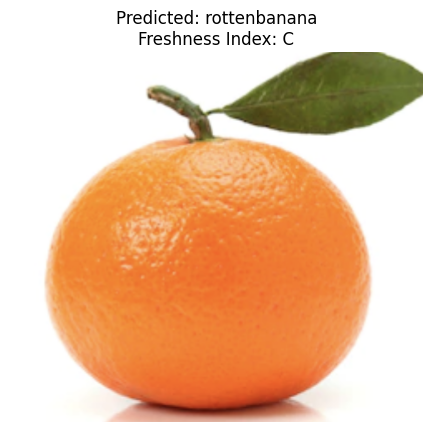

Predicted Class: rottenbanana
Freshness Index: C


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load the trained model
model = tf.keras.models.load_model('/kaggle/working/my_fruit_classifier.h5')

# Define a mapping from the six classes to the three freshness categories (A, B, C)
class_to_freshness = {
    0: 'A',  # Assuming class 0 is fresh (e.g., freshapples)
    1: 'A',  # Assuming class 1 is fresh (e.g., freshbanana)
    2: 'B',  # Assuming class 2 is edible (e.g., freshoranges)
    3: 'C',  # Assuming class 3 is rotten (e.g., rottenapples)
    4: 'C',  # Assuming class 4 is rotten (e.g., rottenbanana)
    5: 'C',  # Assuming class 5 is rotten (e.g., rottenoranges)
}

# Define a function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # Match the input size
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess (MobileNetV2 specific)
    return img_array

# Define a function to get the freshness index
def get_freshness_index(predicted_class):
    return class_to_freshness[predicted_class]  # Get freshness category (A, B, or C)

# Path to the image you want to test
test_image_path = "/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/freshoranges/Screen Shot 2018-06-12 at 11.50.14 PM.png"  # Replace with your image path

# Load and preprocess the image
img = load_and_preprocess_image(test_image_path)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions, axis=-1)[0]

# Get the predicted class name and freshness index
class_names = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']  # Replace with your class names
predicted_label = class_names[predicted_class]
freshness_index = get_freshness_index(predicted_class)

# Display the image and prediction
plt.imshow(image.load_img(test_image_path))  # Display the original image
plt.title(f'Predicted: {predicted_label}\nFreshness Index: {freshness_index}')
plt.axis('off')
plt.show()

# Print the prediction and freshness index
print(f"Predicted Class: {predicted_label}")
print(f"Freshness Index: {freshness_index}")


In [ ]:
MOBILENET

Found 10901 files belonging to 6 classes.
Found 2698 files belonging to 6 classes.
Found 8723 images belonging to 6 classes.
Found 2178 images belonging to 6 classes.


/tmp/ipykernel_30/2600474680.py:80: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.4250 - loss: 1.6947 - val_accuracy: 0.7098 - val_loss: 0.7916
Epoch 2/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.6009 - loss: 0.9993 - val_accuracy: 0.7649 - val_loss: 0.6599
Epoch 3/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.6393 - loss: 0.9363 - val_accuracy: 0.7943 - val_loss: 0.5841
Epoch 4/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.6710 - loss: 0.8720 - val_accuracy: 0.7902 - val_loss: 0.6075
Epoch 5/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.6820 - loss: 0.8245 - val_accuracy: 0.7865 - val_loss: 0.5743
Epoch 6/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.6987 - loss: 0.7964 - val_accuracy: 0.8062 - val_loss: 0.5442
Epoch 7/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7094 - loss: 0.7693 - val_accuracy: 0.8076 - val_loss: 0.5328
Epoch 8/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.7015 - loss: 0.7742 - val_accu

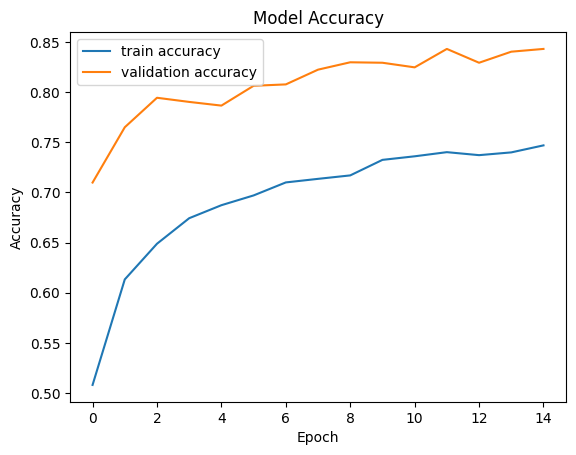

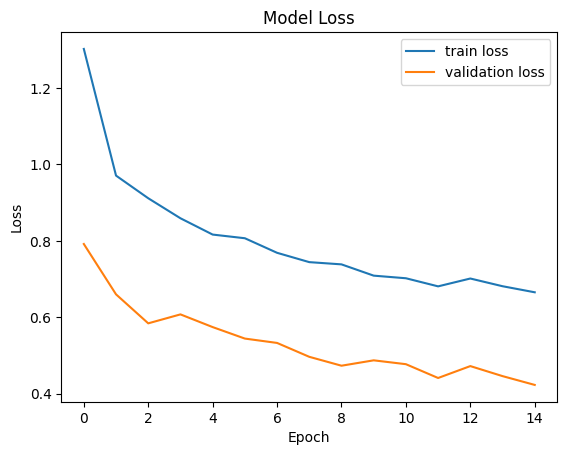

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Define paths
dataset_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/'
train_data_dir = os.path.join(dataset_path, 'dataset/train/')
test_data_dir = os.path.join(dataset_path, 'dataset/test/')

# Use tf.data.Dataset for loading and preprocessing the images
BATCH_SIZE = 64
IMG_SIZE = (150, 150)

# Load dataset function
def load_dataset(data_dir):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=True
    )
    return dataset

# Load train and test datasets
train_dataset = load_dataset(train_data_dir)
test_dataset = load_dataset(test_data_dir)

# Count class samples for class weights
class_names = train_dataset.class_names
class_counts = np.zeros(len(class_names))

for images, labels in train_dataset:
    for label in labels.numpy():
        class_counts[np.argmax(label)] += 1

# Calculate class weights
total_samples = sum(class_counts)
class_weights = {i: total_samples / (len(class_names) * count) for i, count in enumerate(class_counts)}

# Enhanced Data Augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use a portion of the data for validation
)

# Create training and validation datasets with augmentation
train_dataset = data_augmentation.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_dataset = data_augmentation.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Use MobileNetV2 pre-trained model as the base
def create_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False  # Freeze the base model layers for transfer learning

    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(class_names), activation='softmax')  # Number of classes
    ])
    return model

# Create and compile the model
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_dataset,
    epochs=15,  # Adjust number of epochs
    validation_data=validation_dataset,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Save the trained model
model.save('/kaggle/working/my_fruit_classifier.h5')

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Class Probabilities: [1.9323374e-03 3.7260525e-05 1.3425397e-05 3.3081657e-01 5.0726199e-01
 1.5993842e-01]


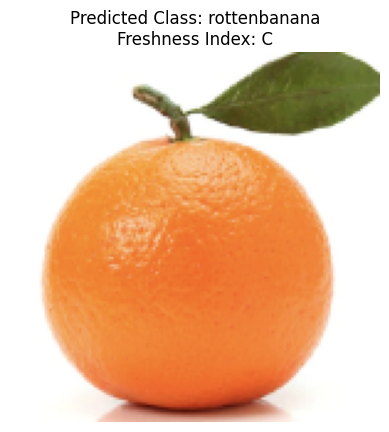

Prediction Values: [[1.9323374e-03 3.7260525e-05 1.3425397e-05 3.3081657e-01 5.0726199e-01
  1.5993842e-01]]
Freshness Index: C


In [16]:
# Function to predict the class of an image
def predict_image(model, img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])  # Get the class index
    predicted_class_name = train_dataset.class_indices  # Get class names
    predicted_class_name = list(predicted_class_name.keys())[list(predicted_class_name.values()).index(predicted_class_index)]
    
    # Print the class probabilities for debugging
    print(f"Class Probabilities: {predictions[0]}")
    
    return predicted_class_name, predictions

# Test with a different image to see if it's still predicting the same
test_image_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/freshoranges/Screen Shot 2018-06-12 at 11.50.14 PM.png'

# Make the prediction
predicted_class, prediction_values = predict_image(model, test_image_path)

# Get freshness index
freshness_index = get_freshness_index(predicted_class)

# Display the image and the prediction with freshness index
plt.imshow(image.load_img(test_image_path, target_size=(150, 150)))
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class}\nFreshness Index: {freshness_index}')
plt.show()

print(f'Prediction Values: {prediction_values}')
print(f'Freshness Index: {freshness_index}')


In [ ]:
#FINAL MODEL

Found 10901 files belonging to 6 classes.
Found 2698 files belonging to 6 classes.
Found 8723 images belonging to 6 classes.
Found 2178 images belonging to 6 classes.


/tmp/ipykernel_30/3768380679.py:67: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 158s 849ms/step - accuracy: 0.2540 - loss: 2.0866 - val_accuracy: 0.3251 - val_loss: 1.9647
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 103s 723ms/step - accuracy: 0.6005 - loss: 1.0616 - val_accuracy: 0.5588 - val_loss: 1.2162
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 103s 720ms/step - accuracy: 0.7863 - loss: 0.6426 - val_accuracy: 0.6993 - val_loss: 0.8253
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 103s 723ms/step - accuracy: 0.8615 - loss: 0.4273 - val_accuracy: 0.7874 - val_loss: 0.6536
Epoch 5/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 103s 721ms/step - accuracy: 0.8938 - loss: 0.3322 - val_accuracy: 0.8476 - val_loss: 0.4759
Epoch 6/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 103s 723ms/step - accuracy: 0.9168 - loss: 0.2625 - val_accuracy: 0.8921 - val_loss: 0.3365
Epoch 7/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 103s 721ms/step - accuracy: 0.9313 - loss: 0.2169 - val_accuracy: 0.9141 - val_loss: 0.2574
Epoch 8/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 104s 726ms/step - accuracy: 0.9440 -

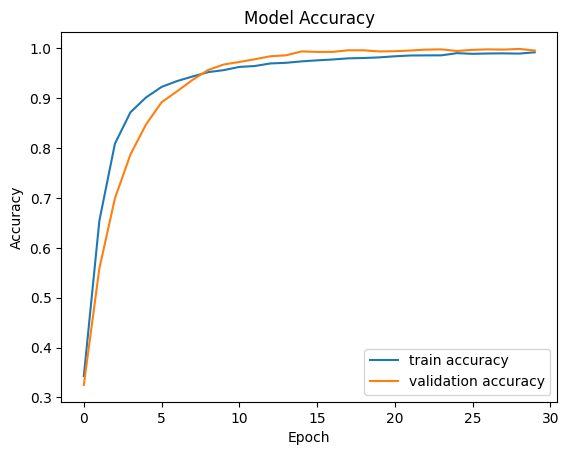

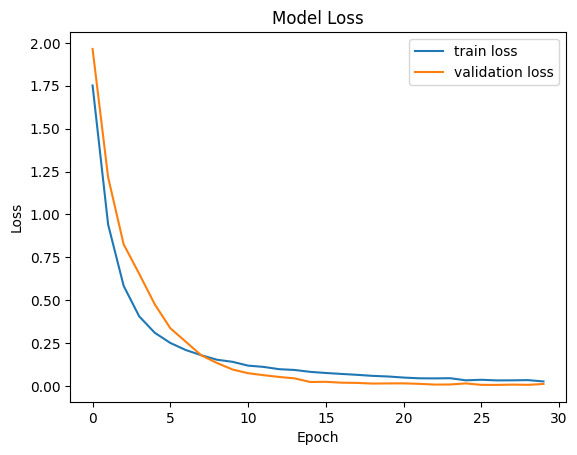

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Attention
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Define paths
dataset_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/'
train_data_dir = os.path.join(dataset_path, 'dataset/train/')
test_data_dir = os.path.join(dataset_path, 'dataset/test/')

# Use tf.data.Dataset for loading and preprocessing the images
BATCH_SIZE = 64
IMG_SIZE = (150, 150)

# Load dataset function
def load_dataset(data_dir):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=True
    )
    return dataset

# Load train and test datasets
train_dataset = load_dataset(train_data_dir)
test_dataset = load_dataset(test_data_dir)

# Enhanced Data Augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use a portion of the data for validation
)

# Create training and validation datasets with augmentation
train_dataset = data_augmentation.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_dataset = data_augmentation.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Use MobileNetV2 pre-trained model as the base with fine-tuning
def create_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    
    # Fine-tune some layers in the base model
    for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers for fine-tuning
        layer.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(train_dataset.class_indices), activation='softmax')  # Number of classes
    ])
    
    return model

# Create and compile the model
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Adjusted learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_dataset,
    epochs=30,  # Increased number of epochs for better training
    validation_data=validation_dataset,
    callbacks=[early_stopping]
)

# Save the trained model
model.save('/kaggle/working/my_fruit_classifier.h5')

# Evaluate the model on test dataset
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot training history for accuracy and loss visualization
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Class Indices: {'freshapples': 0, 'freshbanana': 1, 'freshoranges': 2, 'rottenapples': 3, 'rottenbanana': 4, 'rottenoranges': 5}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Raw Model Predictions: [[0.29731363 0.31485844 0.08997506 0.07820253 0.1567132  0.0629372 ]]
Predicted Class Name: freshbanana
Freshness Index: A


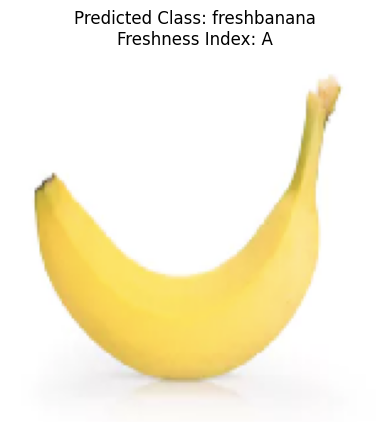

Predicted Class: freshbanana, Freshness Index: A


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # Resize to match model's expected input
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess input for MobileNetV2
    return img_array

# Function to predict freshness index based on class name
def get_freshness_index(predicted_class):
    # Define a mapping from class names to freshness indices
    freshness_mapping = {
        'freshorange': 'A',  # Fresh oranges
        'rottenorange': 'C', # Rotten oranges
        'freshapple': 'A',   # Fresh apples
        'rottenapple': 'C',  # Rotten apples
        'freshbanana': 'A',  # Fresh bananas
        'rottenbanana': 'C', # Rotten bananas
    }
    
    # Normalize the class name and return the freshness index
    predicted_class = predicted_class.lower()
    if predicted_class in freshness_mapping:
        return freshness_mapping[predicted_class]
    else:
        return 'B'  # Default to 'B' if it's not clearly 'fresh' or 'rotten'

# Function to predict the class of an image
def predict_image(model, img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    
    predicted_class_index = np.argmax(predictions[0])  # Get the class index
    predicted_class_name = list(train_dataset.class_indices.keys())[predicted_class_index]
    
    return predicted_class_name

# Test with an image to check prediction and freshness index
test_image_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/freshbanana/Screen Shot 2018-06-12 at 10.00.37 PM.png'

# Debug: Check class indices
print(f"Class Indices: {train_dataset.class_indices}")

# Load and predict
predicted_class = predict_image(model, test_image_path)

# Debug: Check raw model predictions
img_array = load_and_preprocess_image(test_image_path)
predictions = model.predict(img_array)
print(f"Raw Model Predictions: {predictions}")

# Print the predicted class name
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = list(train_dataset.class_indices.keys())[list(train_dataset.class_indices.values()).index(predicted_class_index)]
print(f"Predicted Class Name: {predicted_class_name}")

# Get freshness index based on predicted class
freshness_index = get_freshness_index(predicted_class_name)
print(f"Freshness Index: {freshness_index}")

# Display the image and prediction results
plt.imshow(image.load_img(test_image_path, target_size=(150, 150)))
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_name}\nFreshness Index: {freshness_index}')
plt.show()

# Print the final output for clarity
print(f'Predicted Class: {predicted_class_name}, Freshness Index: {freshness_index}')
